## Задание 5
- 1. Прочитайте базу my_BRENT2019.csv
- 2. Добавьте первые разности и стоимости доллара и евро к рублю(можно добавить их 1-е разности)
- 3. сделайте ее перрасчет (ресемплинг) в представление по неделям.
- 4. Постройте модель предсказания 1-й точки от текущей (h=1).
- 5. Добавьте еще один экзогенный фактор - любой:)
- 6. Сравните модель с дополнительным экзогенным фактором и исходную и сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Brent 2010-2019
Цена нефти марки Brent. Данные по дням от 2010/09/01 до 2019/09/01 . Данные были обработаны, но не меняли основное содержание ключевого признака. Отличие от исходного описания - дополнение признаками по календарю.

In [27]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.tail()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2019-08-27,59.59,2019,8,27,3,239,35,1,0,0,0
2019-08-28,59.84,2019,8,28,3,240,35,2,0,0,0
2019-08-29,60.37,2019,8,29,3,241,35,3,0,0,0
2019-08-30,59.19,2019,8,30,3,242,35,4,0,0,0
2019-09-01,58.84,2019,9,1,3,244,35,6,0,1,0


In [28]:
first_diff = np.array(brent_data.iloc[1:,0].values - brent_data.iloc[:-1,0].values).astype('float32') 
brent_data['diff1'] = 0.0
brent_data['diff1'] =  brent_data['diff1'].astype('float') 
brent_data['diff1'].values[1:] = first_diff

__Выгрузим данные за аналогичный период с сайта:__

источник данных https://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.FromDate=01.09.2010&UniDbQuery.ToDate=01.09.2019,

In [29]:
rub_usd=pd.read_excel('RC_USD_09_2010_T01_09_2019.xlsx')
rub_usd.index = pd.to_datetime(rub_usd['data'].values).date
rub_usd.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_usd.columns = ['rub_usd_curs']
rub_usd['Date'] = rub_usd.index
rub_usd['Date'] =  rub_usd['Date'].astype('datetime64')
rub_usd.head()

,rub_usd_curs,Date
2010-09-01,30.8669,2010-09-01
2010-09-02,30.8001,2010-09-02
2010-09-03,30.6858,2010-09-03
2010-09-04,30.6922,2010-09-04
2010-09-07,30.5771,2010-09-07


In [30]:
rub_eur=pd.read_excel('RC_EUR_09_2010_T01_09_2019.xlsx')
rub_eur.index = pd.to_datetime(rub_eur['data'].values).date
rub_eur.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_eur.columns = ['rub_eur_curs']
rub_eur['Date'] = rub_eur.index
rub_eur['Date'] =  rub_eur['Date'].astype('datetime64')
rub_eur.head()

,rub_eur_curs,Date
2010-09-01,39.0127,2010-09-01
2010-09-02,39.1654,2010-09-02
2010-09-03,39.2901,2010-09-03
2010-09-04,39.3505,2010-09-04
2010-09-07,39.4720,2010-09-07


In [31]:
#добавим столбец с Датой, пригодится для слияния
brent_data['Date'] = brent_data.index
brent_data['Date'] =  brent_data['Date'].astype('datetime64')
brent_data.shape

(2667, 13)

In [32]:
brent_data_curs = pd.merge(brent_data, rub_usd, on='Date', how='left')
brent_data_curses = pd.merge(brent_data_curs, rub_eur, on='Date', how='left')
brent_data_curses = brent_data_curses.fillna(method='ffill')
brent_data_curses.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff1,Date,rub_usd_curs,rub_eur_curs
0,76.37,2010,9,1,3,244,35,2,0,0,0,0.00,2010-09-01,30.8669,39.0127
1,76.89,2010,9,2,3,245,35,3,0,0,0,0.52,2010-09-02,30.8001,39.1654
2,76.57,2010,9,3,3,246,35,4,0,0,0,-0.32,2010-09-03,30.6858,39.2901
3,76.62,2010,9,4,3,247,35,5,0,0,0,0.05,2010-09-04,30.6922,39.3505
4,76.63,2010,9,5,3,248,35,6,0,1,0,0.01,2010-09-05,30.6922,39.3505


### 2. Добавьте первые разности и стоимости доллара и евро к рублю(можно добавить их 1-е разности)
### 3. Сделайте ее перрасчет (ресемплинг) в представление по неделям.

In [33]:
first_diff_usd = np.array(brent_data_curses['rub_usd_curs'].values[1:] - brent_data_curses['rub_usd_curs'].values[:-1]).astype('float32') 
brent_data_curses['usd_diff1'] = 0.0
brent_data_curses['usd_diff1'] =  brent_data_curses['usd_diff1'].astype('float') 
brent_data_curses['usd_diff1'].values[1:] = first_diff_usd

In [34]:
first_diff_eur = np.array(brent_data_curses['rub_eur_curs'].values[1:] - brent_data_curses['rub_eur_curs'].values[:-1]).astype('float32') 
brent_data_curses['eur_diff1'] = 0.0
brent_data_curses['eur_diff1'] =  brent_data_curses['eur_diff1'].astype('float') 
brent_data_curses['eur_diff1'].values[1:] = first_diff_eur

In [35]:
brent_data_curses = brent_data_curses.set_index(['Date'])
brent_data_curses.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff1,rub_usd_curs,rub_eur_curs,usd_diff1,eur_diff1
Date,,,,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0.00,30.8669,39.0127,0.0000,0.0000
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,0.52,30.8001,39.1654,-0.0668,0.1527
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,-0.32,30.6858,39.2901,-0.1143,0.1247
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,0.05,30.6922,39.3505,0.0064,0.0604
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,0.01,30.6922,39.3505,0.0000,0.0000


__Посмотрим на первые разности. Помним, что для BRENT первые разности стационарны. Проверим как выглядят они для кросс-курсов.__

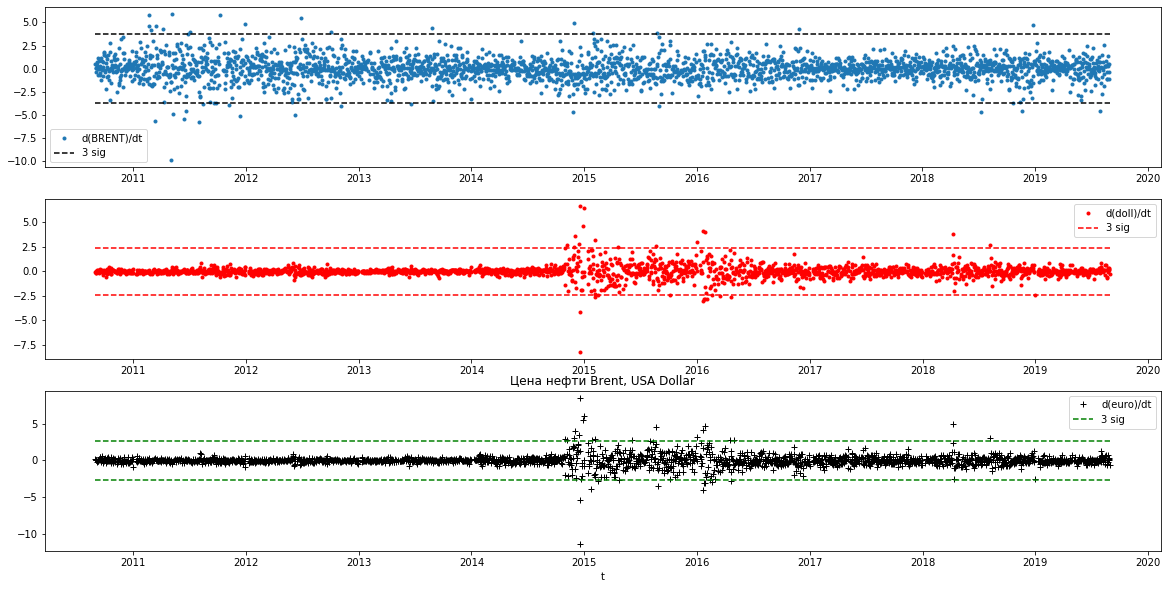

In [36]:
d_brent_data = brent_data['Значение'].values[1:]- brent_data['Значение'].values[:-1]
s_brent = np.std(d_brent_data) *3

d_rub_usd = rub_usd['rub_usd_curs'].values[1:]- rub_usd['rub_usd_curs'].values[:-1]
s_rub = np.std(d_rub_usd)**0.5 *3

d_rub_eur = rub_eur['rub_eur_curs'].values[1:]- rub_eur['rub_eur_curs'].values[:-1]
s_rube = np.std(d_rub_eur)**0.5 *3

plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(brent_data.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.legend()

plt.subplot(3,1,2)
plt.plot(rub_usd.iloc[:-1].index,d_rub_usd,'.r', label='d(doll)/dt')
plt.plot(rub_usd.iloc[[0,-1]].index,[s_rub, s_rub],'--r',label ='3 sig')
plt.plot(rub_usd.iloc[[0,-1]].index,[-s_rub, -s_rub],'--r')
plt.legend()

plt.subplot(3,1,3)
plt.plot(rub_eur.iloc[:-1].index,d_rub_eur,'+k', label='d(euro)/dt')
plt.plot(rub_eur.iloc[[0,-1]].index,[s_rube, s_rube],'--g',label ='3 sig')
plt.plot(rub_eur.iloc[[0,-1]].index,[-s_rube, -s_rube],'--g')

plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

ind_anomal_brent = np.where( abs(d_brent_data)>s_brent)[0]
ind_anomal_rubl_d = np.where( abs(d_rub_usd)>s_rub)[0]
ind_anomal_rubl_e = np.where( abs(d_rub_eur)>s_rube)[0]


### РЕСЕМПЛИНГ

In [37]:
brent_data_w=brent_data_curses.resample('W').mean()
brent_data_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff1,rub_usd_curs,rub_eur_curs,usd_diff1,eur_diff1
Date,,,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000,0.052000,30.747440,39.233840,-0.034940,0.067560
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667,0.288333,30.777050,39.302883,0.033583,-0.026467
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000,-0.021667,30.844500,39.764250,0.021433,0.187483
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000,0.118333,31.012233,40.967983,-0.003200,0.203567
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000,0.791667,30.607417,41.345817,-0.081750,-0.016467


In [38]:
#уберем ненужные столбцы, потерявшие смысл после ресемплинга
brent_data_w.drop(['dayofmonth', 'dayofyear', 'dayofweek'], axis=1,inplace=True)
brent_data_w['2011-09-01' : '2011-10-31']

,Значение,year,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,diff1,rub_usd_curs,rub_eur_curs,usd_diff1,eur_diff1
Date,,,,,,,,,,,,,
2011-09-04,113.291667,2011.0,8.500000,3.000000,35.0,0.000000,0.166667,0.000000,0.171667,28.860033,41.661533,0.001433,-0.033567
2011-09-11,112.366667,2011.0,9.000000,3.000000,36.0,0.166667,0.000000,0.166667,-0.383333,29.389817,41.526417,0.101733,0.007383
2011-09-18,110.946667,2011.0,9.000000,3.000000,37.0,0.000000,0.000000,0.000000,0.283333,30.227467,41.491183,0.167117,0.060283
2011-09-25,107.106667,2011.0,9.000000,3.000000,38.0,0.000000,0.000000,0.000000,-1.223333,31.350267,42.749717,0.234400,0.227150
2011-10-02,103.878333,2011.0,9.166667,3.166667,39.0,0.000000,0.000000,0.000000,-0.481667,32.026800,43.391450,-0.005917,0.025967
2011-10-09,103.476667,2011.0,10.000000,4.000000,40.0,0.000000,0.166667,0.000000,0.455000,32.466400,43.367483,0.105567,-0.004183
2011-10-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-23,109.756667,2011.0,10.000000,4.000000,42.0,0.000000,0.000000,0.000000,1.806667,31.227767,42.893333,-0.376567,-0.129000
2011-10-30,110.680000,2011.0,10.000000,4.000000,43.0,0.000000,0.000000,0.000000,0.050000,30.626467,42.593517,-0.189450,-0.104783


In [39]:
np.isnan(brent_data_w).sum()

Значение           1
year               1
month              1
quarter            1
weekofyear         1
is_holiday         1
is_prev_holiday    1
is_next_holiday    1
diff1              1
rub_usd_curs       1
rub_eur_curs       1
usd_diff1          1
eur_diff1          1
dtype: int64

__Есть пропуск__
Обработаем как среднее

In [40]:
brent_data_w.loc['2011-10-16'] = (brent_data_w.loc['2011-10-09'] + brent_data_w.loc['2011-10-23'])/2

In [41]:
brent_data_w['2011-09-01' : '2011-10-31']

,Значение,year,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,diff1,rub_usd_curs,rub_eur_curs,usd_diff1,eur_diff1
Date,,,,,,,,,,,,,
2011-09-04,113.291667,2011.0,8.500000,3.000000,35.0,0.000000,0.166667,0.000000,0.171667,28.860033,41.661533,0.001433,-0.033567
2011-09-11,112.366667,2011.0,9.000000,3.000000,36.0,0.166667,0.000000,0.166667,-0.383333,29.389817,41.526417,0.101733,0.007383
2011-09-18,110.946667,2011.0,9.000000,3.000000,37.0,0.000000,0.000000,0.000000,0.283333,30.227467,41.491183,0.167117,0.060283
2011-09-25,107.106667,2011.0,9.000000,3.000000,38.0,0.000000,0.000000,0.000000,-1.223333,31.350267,42.749717,0.234400,0.227150
2011-10-02,103.878333,2011.0,9.166667,3.166667,39.0,0.000000,0.000000,0.000000,-0.481667,32.026800,43.391450,-0.005917,0.025967
2011-10-09,103.476667,2011.0,10.000000,4.000000,40.0,0.000000,0.166667,0.000000,0.455000,32.466400,43.367483,0.105567,-0.004183
2011-10-16,106.616667,2011.0,10.000000,4.000000,41.0,0.000000,0.083333,0.000000,1.130833,31.847083,43.130408,-0.135500,-0.066592
2011-10-23,109.756667,2011.0,10.000000,4.000000,42.0,0.000000,0.000000,0.000000,1.806667,31.227767,42.893333,-0.376567,-0.129000
2011-10-30,110.680000,2011.0,10.000000,4.000000,43.0,0.000000,0.000000,0.000000,0.050000,30.626467,42.593517,-0.189450,-0.104783


In [42]:
np.isnan(brent_data_w).sum()

Значение           0
year               0
month              0
quarter            0
weekofyear         0
is_holiday         0
is_prev_holiday    0
is_next_holiday    0
diff1              0
rub_usd_curs       0
rub_eur_curs       0
usd_diff1          0
eur_diff1          0
dtype: int64

In [43]:
# возьмем выборку чуть меньше, чтобы исключить баг
w_brent_data_ = brent_data_w[75:]

### 4. Постройте модель предсказания 1-й точки от текущей (h=1).

In [45]:
# Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1)
from sklearn.preprocessing import StandardScaler

scl_target=StandardScaler() 
p = 14
h=1
target = w_brent_data_['Значение'].values[h+p:].reshape((w_brent_data_.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(380, 1)

In [46]:
scl_x=StandardScaler() 

X = w_brent_data_.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape
# Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. 
# Таким образом, входной набор данных сформирован.

(380, 13)

In [47]:
# Построим предсказание на всех признаках
from sklearn.ensemble import GradientBoostingRegressor

In [48]:
# сделаем функцию разбиения
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

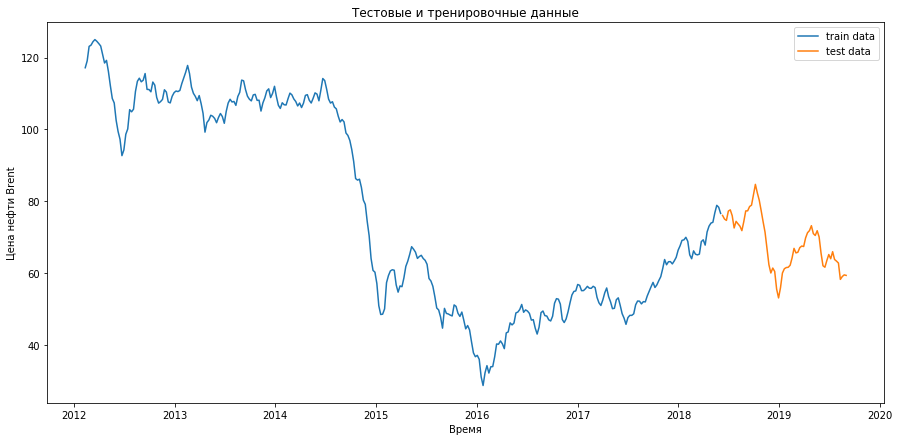

In [49]:
train, test = split_data(w_brent_data_, '06-06-2018')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(train.index.get_level_values('Date'),train['Значение'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['Значение'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [59]:
model_g = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=128)

In [60]:
X_train = X[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test = X[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]

model_g.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=128,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

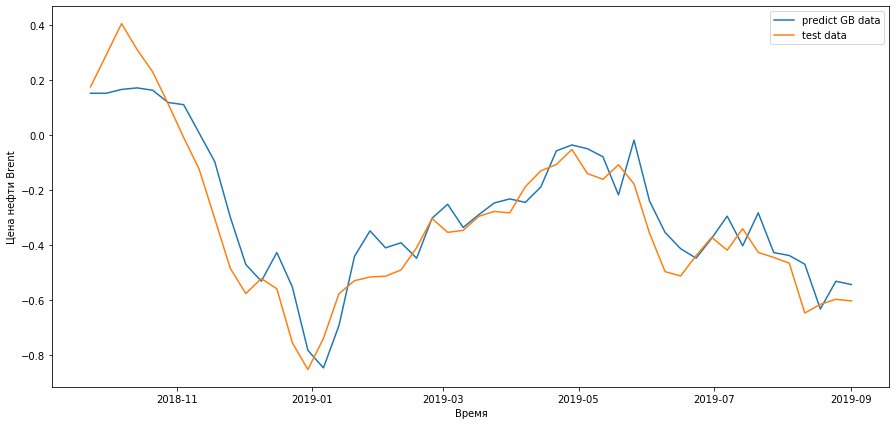

In [61]:
y_test_pred_g = model_g.predict(X_test)

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

In [62]:
#Оценим промах модели, используя метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [63]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [64]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform(y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка mse :   0.011326824680980483 
ошибка mae  :   0.08762650653599272 
оценка R2 :   0.8589716457881358
ошибка градиентного бустинга MAPE :   3.362465670103037 %


In [65]:
#Воспользуемся методом поиска
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15], 
              "n_estimators":[100, 200, 300, 400, 500, 1000, 1200, 1500, 2000, 3000]}

#  randomized search
n_iter_search = 100

model_gr = GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.775 (std: 0.087)
Parameters: {'n_estimators': 500, 'max_depth': 5}

Model with rank: 2
Mean validation score: 0.768 (std: 0.094)
Parameters: {'n_estimators': 1000, 'max_depth': 5}

Model with rank: 3
Mean validation score: 0.767 (std: 0.101)
Parameters: {'n_estimators': 3000, 'max_depth': 5}



### Выбираем модель с рангом 1 Parameters: {'n_estimators': 500, 'max_depth': 5} и проведем ее обучение на тренировочном наборе

In [66]:

model_g_best = GradientBoostingRegressor(max_depth=5, n_estimators=100)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)
print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка mse :   0.011228029197925824 
ошибка mae  :   0.0860784579390018 
оценка R2 :   0.8602017314274201
ошибка градиентного бустинга MAPE :   3.286807585626191 %


#### показатели оценки немного улучшились

### 5. Добавьте еще один экзогенный фактор - любой:)

Возьмем индекс MSCI World Index отсюда
https://investfunds.ru/indexes/25281/

In [71]:
msci=pd.read_excel('msci-world-index.xlsx')
msci.columns = ['Date', 'msci']
msci['Date'] =  msci['Date'].astype('datetime64[ns]')

brent_data_curses_msci = pd.merge(brent_data_curses, msci, on='Date', how='left')
brent_data_curses_msci.head()

,Date,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,diff1,rub_usd_curs,rub_eur_curs,usd_diff1,eur_diff1,msci
0,2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0.00,30.8669,39.0127,0.0000,0.0000,1111.515
1,2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,0.52,30.8001,39.1654,-0.0668,0.1527,1119.147
2,2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,-0.32,30.6858,39.2901,-0.1143,0.1247,1131.487
3,2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,0.05,30.6922,39.3505,0.0064,0.0604,NaN
4,2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,0.01,30.6922,39.3505,0.0000,0.0000,NaN


In [72]:
brent_data_curses_msci = brent_data_curses_msci.set_index(['Date'])
brent_data_curses_msci = brent_data_curses_msci.fillna(method='ffill')
w_brent_data2=brent_data_curses_msci.resample('W').mean()

w_brent_data2.drop(['dayofmonth', 'dayofyear', 'dayofweek'], axis=1,inplace=True)
w_brent_data2.loc['2011-10-16'] = (w_brent_data2.loc['2011-10-09'] + w_brent_data2.loc['2011-10-23'])/2

In [73]:
# возьмем выборку чуть меньше, чтобы исключить баг
w_brent_data_2 = w_brent_data2[75:]
w_brent_data_2.head()

,Значение,year,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,diff1,rub_usd_curs,rub_eur_curs,usd_diff1,eur_diff1,msci
Date,,,,,,,,,,,,,,
2012-02-12,117.163333,2012.0,2.0,1.0,6.0,0.000000,0.000000,0.000000,0.415000,29.926167,39.517367,-0.084333,-0.048283,1276.088833
2012-02-19,119.078333,2012.0,2.0,1.0,7.0,0.000000,0.166667,0.000000,0.556667,30.002867,39.452817,0.088383,-0.026433,1280.657667
2012-02-26,123.106667,2012.0,2.0,1.0,8.0,0.166667,0.000000,0.166667,0.756667,29.846250,39.401150,-0.073433,0.015550,1295.917000
2012-03-04,123.461667,2012.0,2.5,1.0,9.0,0.000000,0.000000,0.000000,-0.288333,29.241500,39.120150,-0.080050,-0.056667,1300.215333
2012-03-11,124.413333,2012.0,3.0,1.0,10.0,0.000000,0.000000,0.000000,0.251667,29.502533,38.929650,0.062200,-0.012933,1283.734833


### 6. Сравните модель с дополнительным экзогенным фактором и исходную и сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [74]:
train2, test2 = split_data(w_brent_data_2, '06-06-2018')

# Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1)
p = 14
h=1
target2 = w_brent_data_2['Значение'].values[h+p:].reshape((w_brent_data_2.shape[0]-h-p,1))
y2 = scl_target.fit_transform(target2)
y2.shape

(380, 1)

In [75]:
X2 = w_brent_data_2.iloc[p:-h,:].values
X2 = scl_x.fit_transform(X2.astype('float64'))
X2.shape

(380, 14)

In [76]:
X_train2 = X2[:train2.shape[0],:]
y_train2 = y2[:train2.shape[0],0]
X_test2 = X2[train2.shape[0]:,:]
y_test2 = y2[train2.shape[0]:,0]

model_g_best.fit(X_train2, y_train2)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

__сравниваем__

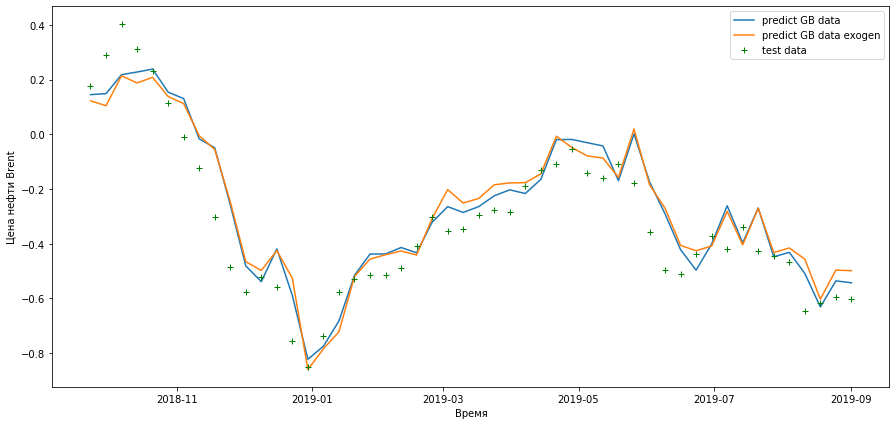

In [84]:
y_test_pred_g2 = model_g_best.predict(X_test2)

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test2.index[h+p:],y_test_pred_g2, label='predict GB data exogen' )
plt.plot(test2.index[h+p:],y_test2,'+g', label='test data')

plt.legend()
plt.show()

In [85]:
er_s = mean_squared_error(y_true=y_test2, y_pred=y_test_pred_g2) 
er_a = mean_absolute_error(y_true=y_test2, y_pred=y_test_pred_g2) 
er_r2 = r2_score(y_true=y_test2, y_pred=y_test_pred_g2)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test2),y_pred = scl_target.inverse_transform(y_test_pred_g2))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка mse :   0.013447041385041105 
ошибка mae  :   0.09305278216918637 
оценка R2 :   0.8325731907252392
ошибка градиентного бустинга MAPE :   3.5669120140631434 %


### Вывод: видим, что все показатели стали хуже с добавлением дополнительного экзогенного фактора